# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

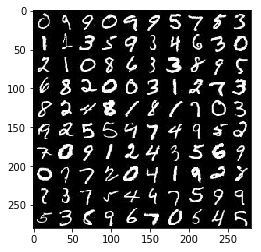

In [2]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

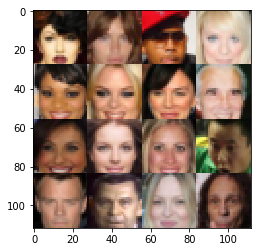

In [3]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None,image_width,image_height,image_channels))
    z_input = tf.placeholder(dtype=tf.float32, shape=(None,z_dim))
    learning_rate = tf.placeholder(dtype=tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.relu(bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.relu(bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.01
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512 now
        
        # Second layer with transpose
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x256 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x5 now
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    discr_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    gener_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discr_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gener_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    idx = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                idx += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if idx % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if idx % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7331... Generator Loss: 0.0821
Epoch 1/2... Discriminator Loss: 3.7791... Generator Loss: 0.0306
Epoch 1/2... Discriminator Loss: 3.0459... Generator Loss: 0.0946
Epoch 1/2... Discriminator Loss: 3.1009... Generator Loss: 0.1226
Epoch 1/2... Discriminator Loss: 2.5932... Generator Loss: 0.1795
Epoch 1/2... Discriminator Loss: 2.2040... Generator Loss: 0.2224
Epoch 1/2... Discriminator Loss: 2.1268... Generator Loss: 0.2790
Epoch 1/2... Discriminator Loss: 2.0646... Generator Loss: 0.4940
Epoch 1/2... Discriminator Loss: 2.0954... Generator Loss: 0.4413


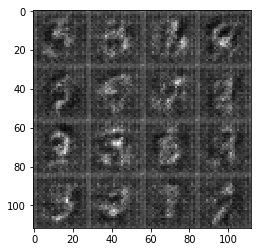

Epoch 1/2... Discriminator Loss: 2.0769... Generator Loss: 0.2420
Epoch 1/2... Discriminator Loss: 1.8443... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 1.9363... Generator Loss: 0.2470
Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.7508... Generator Loss: 0.3085
Epoch 1/2... Discriminator Loss: 1.7921... Generator Loss: 0.2828
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.2849
Epoch 1/2... Discriminator Loss: 1.6695... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.5302


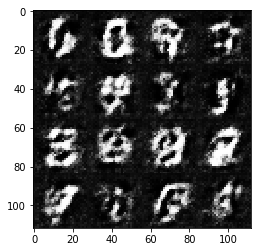

Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.4378... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.3786
Epoch 1/2... Discriminator Loss: 1.6758... Generator Loss: 0.2878
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.7684... Generator Loss: 0.3013
Epoch 1/2... Discriminator Loss: 1.6045... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.4951... Generator Loss: 0.3753


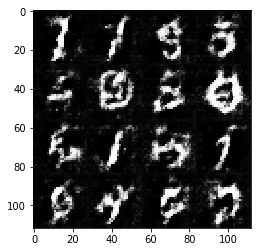

Epoch 1/2... Discriminator Loss: 1.7137... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.5982... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.5957... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 1.5591... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 1.8659... Generator Loss: 0.2417
Epoch 1/2... Discriminator Loss: 1.8323... Generator Loss: 0.2530
Epoch 1/2... Discriminator Loss: 1.7151... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.7425... Generator Loss: 0.3076
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.7996... Generator Loss: 0.3942


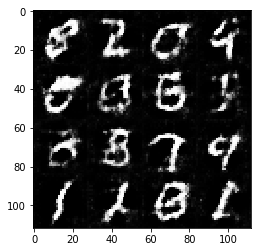

Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.4476
Epoch 1/2... Discriminator Loss: 1.7108... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.5235
Epoch 1/2... Discriminator Loss: 1.7534... Generator Loss: 0.2971
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.3871
Epoch 1/2... Discriminator Loss: 1.6819... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 1.8567... Generator Loss: 0.2358
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.7050... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 1.5829... Generator Loss: 0.6149


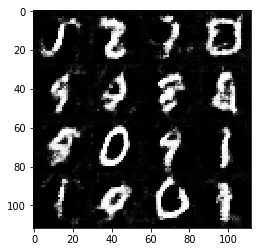

Epoch 1/2... Discriminator Loss: 1.8843... Generator Loss: 0.2674
Epoch 1/2... Discriminator Loss: 1.5788... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.8754... Generator Loss: 0.2349
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.3247
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 0.3978
Epoch 1/2... Discriminator Loss: 1.6637... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 1.6263... Generator Loss: 0.3494
Epoch 1/2... Discriminator Loss: 1.6369... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 0.8378


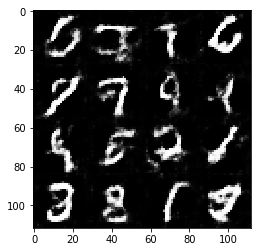

Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.3734
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.7519... Generator Loss: 0.2916
Epoch 1/2... Discriminator Loss: 1.6477... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.4590... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.4062
Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 0.4953
Epoch 1/2... Discriminator Loss: 1.5927... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.4838... Generator Loss: 0.6464


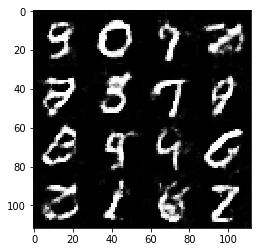

Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 1.7929... Generator Loss: 0.3260
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.5036
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4857
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.5137
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.6079... Generator Loss: 0.3971
Epoch 1/2... Discriminator Loss: 1.5730... Generator Loss: 0.4920
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.4080


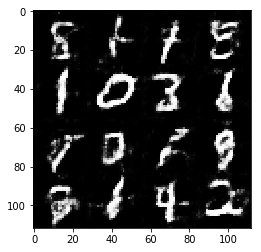

Epoch 1/2... Discriminator Loss: 1.6410... Generator Loss: 0.3493
Epoch 1/2... Discriminator Loss: 1.7372... Generator Loss: 0.3737
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 1.5525... Generator Loss: 0.4513
Epoch 1/2... Discriminator Loss: 1.5641... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.4400... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.5432... Generator Loss: 0.3908
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.6534... Generator Loss: 0.3688
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.4397


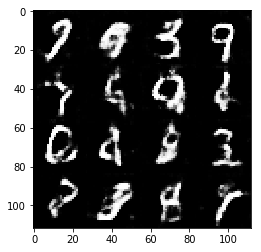

Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.6182... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.2931
Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.6096
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.4094... Generator Loss: 0.5114


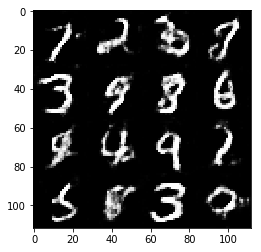

Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.4412
Epoch 1/2... Discriminator Loss: 1.6413... Generator Loss: 0.4033
Epoch 1/2... Discriminator Loss: 1.6952... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.6755... Generator Loss: 0.2908
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 1.6780... Generator Loss: 0.3071
Epoch 1/2... Discriminator Loss: 1.7856... Generator Loss: 0.2708
Epoch 1/2... Discriminator Loss: 1.7128... Generator Loss: 0.2994
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.6760


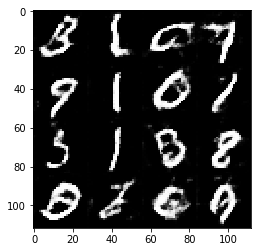

Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 0.4729
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 1.6263... Generator Loss: 0.4571
Epoch 1/2... Discriminator Loss: 1.5587... Generator Loss: 0.4293
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.6015... Generator Loss: 0.4866
Epoch 1/2... Discriminator Loss: 1.4610... Generator Loss: 0.5428
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.4993
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4568
Epoch 1/2... Discriminator Loss: 1.4921... Generator Loss: 0.4673


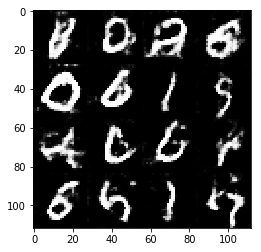

Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 0.3128
Epoch 1/2... Discriminator Loss: 1.6086... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 1.7854... Generator Loss: 0.3155
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 1.5931... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.4055... Generator Loss: 0.7692
Epoch 1/2... Discriminator Loss: 1.5901... Generator Loss: 0.3869


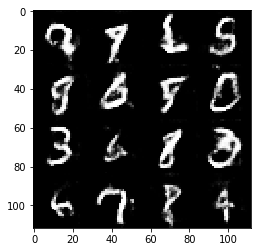

Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.5199... Generator Loss: 0.4572
Epoch 1/2... Discriminator Loss: 1.6070... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.7880... Generator Loss: 0.2684
Epoch 1/2... Discriminator Loss: 1.5418... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.5144... Generator Loss: 0.4397
Epoch 1/2... Discriminator Loss: 1.7636... Generator Loss: 0.3214
Epoch 1/2... Discriminator Loss: 1.6098... Generator Loss: 0.3819
Epoch 1/2... Discriminator Loss: 1.6561... Generator Loss: 0.3520


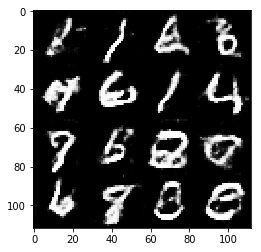

Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.3595
Epoch 1/2... Discriminator Loss: 1.7213... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 1.7570... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 1.6097... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.4631
Epoch 1/2... Discriminator Loss: 1.5081... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.5888... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.7303... Generator Loss: 0.3158
Epoch 1/2... Discriminator Loss: 1.5275... Generator Loss: 0.4258


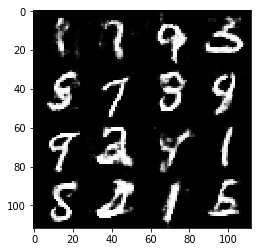

Epoch 1/2... Discriminator Loss: 1.5628... Generator Loss: 0.3701
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 0.3368
Epoch 1/2... Discriminator Loss: 1.5824... Generator Loss: 0.3672
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 0.4146
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.3542
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.3589
Epoch 1/2... Discriminator Loss: 1.7330... Generator Loss: 0.3083
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.5877
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.2577


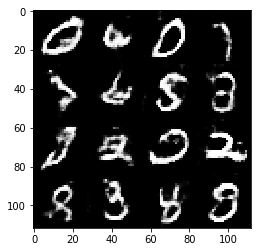

Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 1.6412... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 1.8044... Generator Loss: 0.2777
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.5249
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.5294
Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.3577
Epoch 1/2... Discriminator Loss: 1.5533... Generator Loss: 0.4756


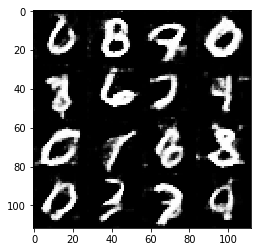

Epoch 1/2... Discriminator Loss: 1.5681... Generator Loss: 0.4181
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.6014
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.4526
Epoch 1/2... Discriminator Loss: 1.7774... Generator Loss: 0.3006
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.3884
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.3509
Epoch 1/2... Discriminator Loss: 1.4380... Generator Loss: 0.4796


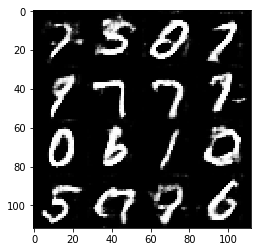

Epoch 1/2... Discriminator Loss: 1.5710... Generator Loss: 0.4442
Epoch 1/2... Discriminator Loss: 1.5401... Generator Loss: 0.3402
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.5639... Generator Loss: 0.3412
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.8480... Generator Loss: 0.2555
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.4035
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.6390... Generator Loss: 0.3441


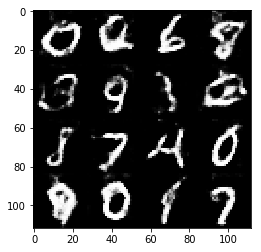

Epoch 2/2... Discriminator Loss: 1.6156... Generator Loss: 0.3105
Epoch 2/2... Discriminator Loss: 1.7514... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 0.5130
Epoch 2/2... Discriminator Loss: 1.6732... Generator Loss: 0.3127
Epoch 2/2... Discriminator Loss: 1.6272... Generator Loss: 0.3089
Epoch 2/2... Discriminator Loss: 1.6513... Generator Loss: 0.2841
Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.4949
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.5496
Epoch 2/2... Discriminator Loss: 1.5976... Generator Loss: 0.3617
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 0.4072


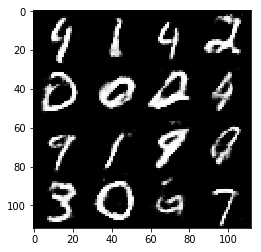

Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 1.8484... Generator Loss: 0.2448
Epoch 2/2... Discriminator Loss: 1.4771... Generator Loss: 0.3819
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 0.5646
Epoch 2/2... Discriminator Loss: 1.3074... Generator Loss: 0.5382
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 1.7792... Generator Loss: 0.2438
Epoch 2/2... Discriminator Loss: 1.5085... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.5140


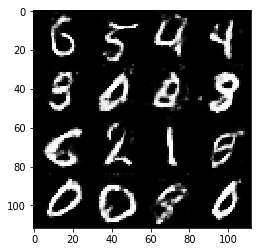

Epoch 2/2... Discriminator Loss: 1.6041... Generator Loss: 0.3369
Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.4065
Epoch 2/2... Discriminator Loss: 1.3719... Generator Loss: 0.4759
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 1.6658... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 1.5685... Generator Loss: 0.4535
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.8545... Generator Loss: 0.2107
Epoch 2/2... Discriminator Loss: 1.8085... Generator Loss: 0.2789


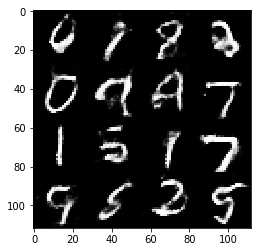

Epoch 2/2... Discriminator Loss: 1.6196... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 1.6594... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 1.5528... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 1.6080... Generator Loss: 0.3413
Epoch 2/2... Discriminator Loss: 1.5429... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.3914
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 1.6757... Generator Loss: 0.3324
Epoch 2/2... Discriminator Loss: 1.5683... Generator Loss: 0.3779


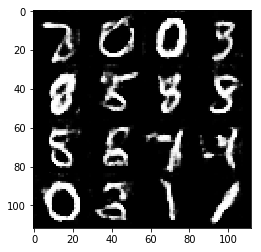

Epoch 2/2... Discriminator Loss: 1.1911... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 1.7514... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 1.5320... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.6821... Generator Loss: 0.2961
Epoch 2/2... Discriminator Loss: 1.8320... Generator Loss: 0.2457
Epoch 2/2... Discriminator Loss: 1.6061... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.6152


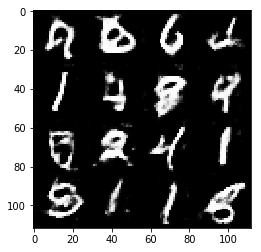

Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.4889
Epoch 2/2... Discriminator Loss: 1.5415... Generator Loss: 0.3336
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.4213
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 1.7862... Generator Loss: 0.2416
Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.5416
Epoch 2/2... Discriminator Loss: 1.7645... Generator Loss: 0.2311
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.7006... Generator Loss: 0.3169


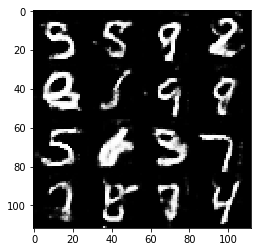

Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.3509
Epoch 2/2... Discriminator Loss: 1.7591... Generator Loss: 0.2542
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.4862... Generator Loss: 0.4566
Epoch 2/2... Discriminator Loss: 1.8437... Generator Loss: 0.2621
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.7563... Generator Loss: 0.2579
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 1.6270... Generator Loss: 0.3684


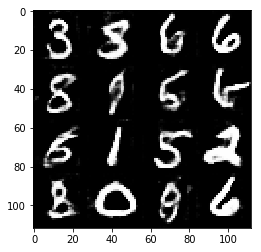

Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.3973
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 1.6720... Generator Loss: 0.3745
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.7241
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.7306... Generator Loss: 0.3004
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.3517
Epoch 2/2... Discriminator Loss: 1.7498... Generator Loss: 0.2906
Epoch 2/2... Discriminator Loss: 2.0316... Generator Loss: 0.1898


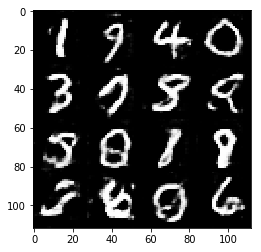

Epoch 2/2... Discriminator Loss: 1.5496... Generator Loss: 0.4493
Epoch 2/2... Discriminator Loss: 1.9198... Generator Loss: 0.2035
Epoch 2/2... Discriminator Loss: 1.8165... Generator Loss: 0.2204
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 1.6659... Generator Loss: 0.2958
Epoch 2/2... Discriminator Loss: 1.5970... Generator Loss: 0.3622
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.4041
Epoch 2/2... Discriminator Loss: 1.9553... Generator Loss: 0.2152
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.4488


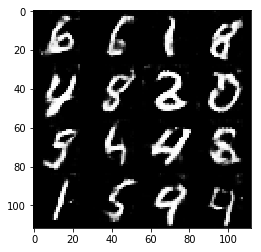

Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.5224... Generator Loss: 0.3809
Epoch 2/2... Discriminator Loss: 1.4577... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.6258... Generator Loss: 0.3450
Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.9488... Generator Loss: 0.1924
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.4436
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.6128


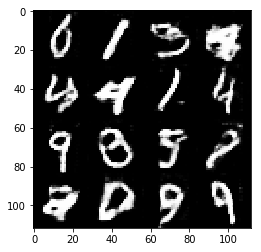

Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.4023
Epoch 2/2... Discriminator Loss: 1.7165... Generator Loss: 0.2585
Epoch 2/2... Discriminator Loss: 1.5740... Generator Loss: 0.3674
Epoch 2/2... Discriminator Loss: 1.4665... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.9293... Generator Loss: 0.1995
Epoch 2/2... Discriminator Loss: 1.7039... Generator Loss: 0.2710
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.3837
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.3575
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.4566


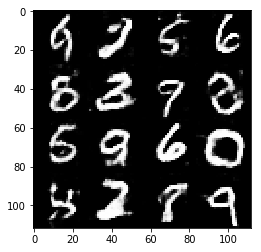

Epoch 2/2... Discriminator Loss: 1.9231... Generator Loss: 0.2263
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.3930... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.5472
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 1.8726... Generator Loss: 0.2573
Epoch 2/2... Discriminator Loss: 1.6080... Generator Loss: 0.3211
Epoch 2/2... Discriminator Loss: 2.0985... Generator Loss: 0.1580


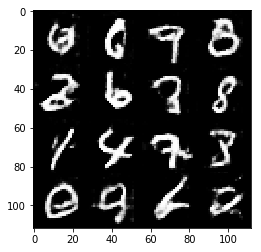

Epoch 2/2... Discriminator Loss: 1.6688... Generator Loss: 0.2713
Epoch 2/2... Discriminator Loss: 1.5659... Generator Loss: 0.6460
Epoch 2/2... Discriminator Loss: 1.5693... Generator Loss: 0.3548
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.8707
Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.5395
Epoch 2/2... Discriminator Loss: 1.6655... Generator Loss: 0.2950
Epoch 2/2... Discriminator Loss: 1.5147... Generator Loss: 0.3857
Epoch 2/2... Discriminator Loss: 1.8070... Generator Loss: 0.2244
Epoch 2/2... Discriminator Loss: 1.8619... Generator Loss: 0.2324


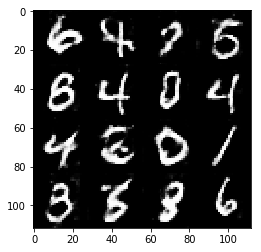

Epoch 2/2... Discriminator Loss: 1.5896... Generator Loss: 0.3449
Epoch 2/2... Discriminator Loss: 1.5310... Generator Loss: 0.3410
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 0.3336
Epoch 2/2... Discriminator Loss: 1.5060... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 1.4202... Generator Loss: 0.4586
Epoch 2/2... Discriminator Loss: 1.7395... Generator Loss: 0.3057
Epoch 2/2... Discriminator Loss: 1.4647... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.5117... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.5088... Generator Loss: 0.3417
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.5023


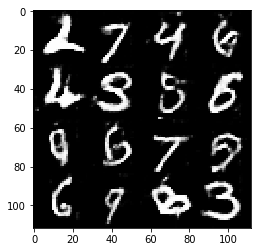

Epoch 2/2... Discriminator Loss: 1.6845... Generator Loss: 0.2663
Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.3012
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.5395... Generator Loss: 0.4448
Epoch 2/2... Discriminator Loss: 1.6244... Generator Loss: 0.3647
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.5602
Epoch 2/2... Discriminator Loss: 1.7045... Generator Loss: 0.2714
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.5833... Generator Loss: 0.3142


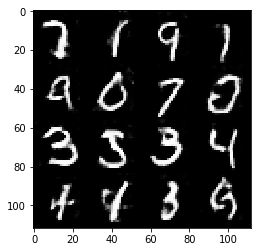

Epoch 2/2... Discriminator Loss: 1.5563... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 1.5784... Generator Loss: 0.2999
Epoch 2/2... Discriminator Loss: 1.8352... Generator Loss: 0.2126
Epoch 2/2... Discriminator Loss: 1.5962... Generator Loss: 0.4023
Epoch 2/2... Discriminator Loss: 1.5697... Generator Loss: 0.3660
Epoch 2/2... Discriminator Loss: 1.4508... Generator Loss: 0.4654
Epoch 2/2... Discriminator Loss: 1.7548... Generator Loss: 0.2854
Epoch 2/2... Discriminator Loss: 1.7019... Generator Loss: 0.2933
Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.9160
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.4145


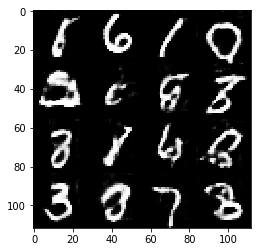

Epoch 2/2... Discriminator Loss: 1.6513... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 1.2461... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 1.3342... Generator Loss: 0.4861
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.3170
Epoch 2/2... Discriminator Loss: 1.6627... Generator Loss: 0.2855
Epoch 2/2... Discriminator Loss: 2.1271... Generator Loss: 0.1561
Epoch 2/2... Discriminator Loss: 1.6851... Generator Loss: 0.2676
Epoch 2/2... Discriminator Loss: 1.5732... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.3901
Epoch 2/2... Discriminator Loss: 1.7008... Generator Loss: 0.4129


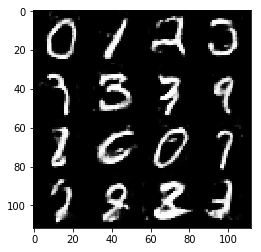

Epoch 2/2... Discriminator Loss: 1.6623... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 0.3453
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.4888
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.3066
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.3328
Epoch 2/2... Discriminator Loss: 1.4246... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 2.0282... Generator Loss: 0.1678
Epoch 2/2... Discriminator Loss: 1.5463... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.5971... Generator Loss: 0.3073


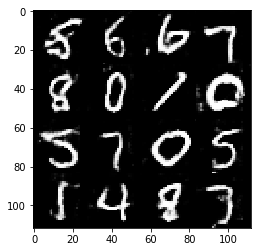

Epoch 2/2... Discriminator Loss: 1.4644... Generator Loss: 0.3868
Epoch 2/2... Discriminator Loss: 1.5576... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.4111
Epoch 2/2... Discriminator Loss: 1.6567... Generator Loss: 0.3452
Epoch 2/2... Discriminator Loss: 1.9584... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.9413


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3373... Generator Loss: 0.0220
Epoch 1/1... Discriminator Loss: 4.1914... Generator Loss: 0.0239
Epoch 1/1... Discriminator Loss: 3.7342... Generator Loss: 0.0355
Epoch 1/1... Discriminator Loss: 3.1009... Generator Loss: 0.2275
Epoch 1/1... Discriminator Loss: 2.5993... Generator Loss: 0.1941
Epoch 1/1... Discriminator Loss: 2.8211... Generator Loss: 0.1190
Epoch 1/1... Discriminator Loss: 2.7769... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 2.7932... Generator Loss: 0.1624
Epoch 1/1... Discriminator Loss: 2.1565... Generator Loss: 0.2124


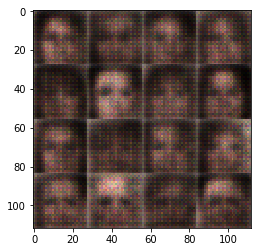

Epoch 1/1... Discriminator Loss: 1.9377... Generator Loss: 0.3117
Epoch 1/1... Discriminator Loss: 1.9352... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.9534... Generator Loss: 0.3480
Epoch 1/1... Discriminator Loss: 1.8948... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 2.3985... Generator Loss: 0.2956
Epoch 1/1... Discriminator Loss: 2.5198... Generator Loss: 0.2041
Epoch 1/1... Discriminator Loss: 1.9448... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 2.0180... Generator Loss: 0.3184
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 0.3530


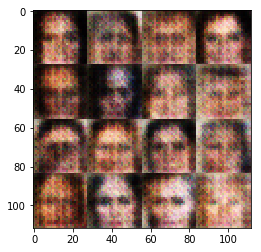

Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.3225
Epoch 1/1... Discriminator Loss: 1.7608... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.7794... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.8836... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.7656... Generator Loss: 0.4462
Epoch 1/1... Discriminator Loss: 1.8135... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.8497... Generator Loss: 0.3730
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.3625
Epoch 1/1... Discriminator Loss: 1.9038... Generator Loss: 0.3416
Epoch 1/1... Discriminator Loss: 1.9208... Generator Loss: 0.3829


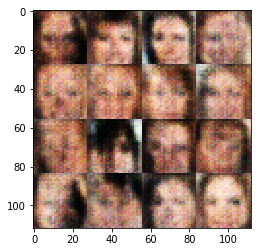

Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.3737
Epoch 1/1... Discriminator Loss: 1.8205... Generator Loss: 0.3866
Epoch 1/1... Discriminator Loss: 1.7210... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 1.8760... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.9046... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.8581... Generator Loss: 0.4152


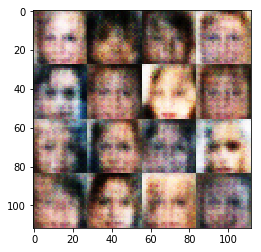

Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.6923... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.6334... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.8421... Generator Loss: 0.4074
Epoch 1/1... Discriminator Loss: 1.6464... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.6774... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.7040... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5670


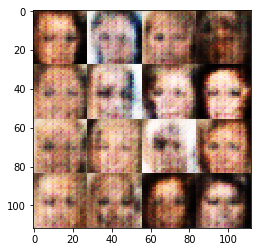

Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.7102... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.4967


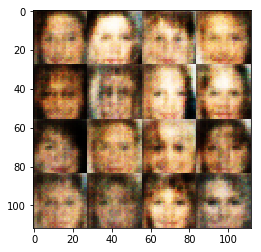

Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.7194... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.5502


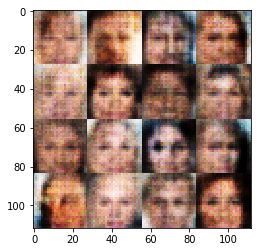

Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.5942... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.5895... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.6148... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.5764


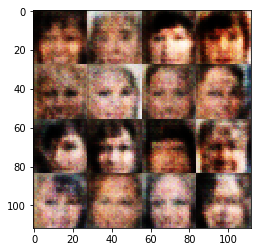

Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.6300... Generator Loss: 0.5053
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5725... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.5325


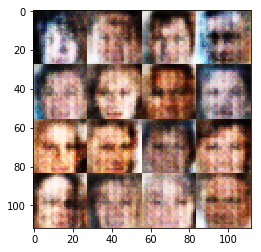

Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.5755... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.6250... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.6650... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 0.5340


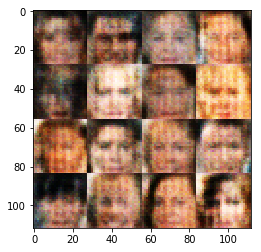

Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.5940


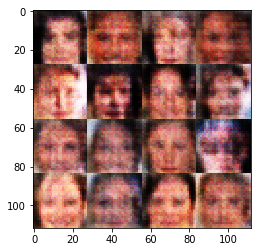

Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.6313... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.5825


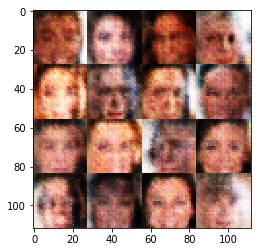

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.5617
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5698


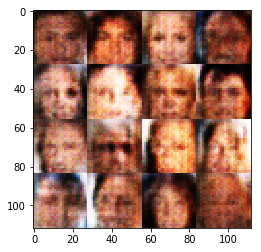

Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6132


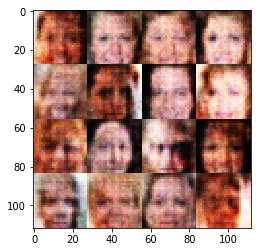

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.3427


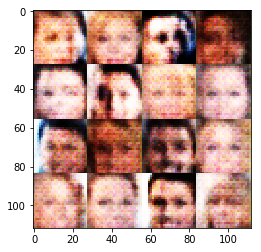

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 4.0050
Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.7623... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 0.7244... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.3399


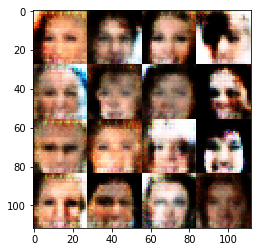

Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.2634
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 4.5352
Epoch 1/1... Discriminator Loss: 1.8477... Generator Loss: 0.2933
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.8427... Generator Loss: 0.2357
Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 1.4686
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.6376... Generator Loss: 0.3596
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.3273


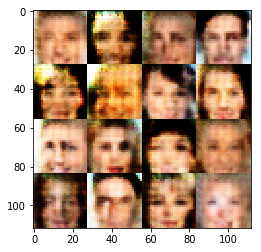

Epoch 1/1... Discriminator Loss: 1.9127... Generator Loss: 0.2607
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.2997
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 2.0130... Generator Loss: 0.2762
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.0366


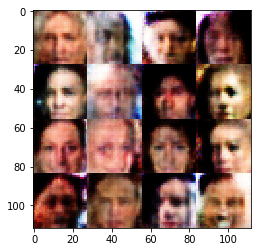

Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.6667... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 1.6219... Generator Loss: 0.3057
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.3902
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.3687
Epoch 1/1... Discriminator Loss: 1.6717... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.7221... Generator Loss: 0.3118


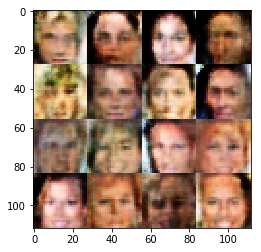

Epoch 1/1... Discriminator Loss: 1.7353... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.7616... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 1.7497... Generator Loss: 0.3131


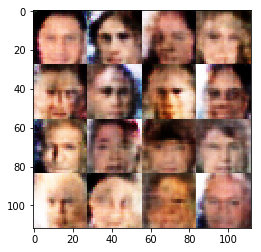

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.7016... Generator Loss: 0.3187
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.7290... Generator Loss: 0.2574
Epoch 1/1... Discriminator Loss: 2.2896... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 1.8004... Generator Loss: 0.6875


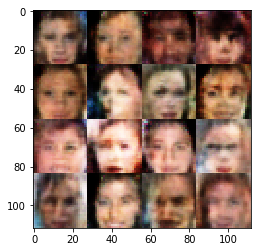

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.2524
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 0.3197
Epoch 1/1... Discriminator Loss: 1.7519... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.4535


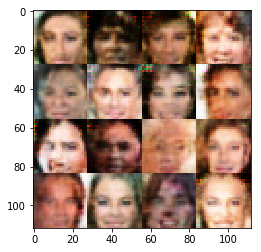

Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 2.1784
Epoch 1/1... Discriminator Loss: 2.0385... Generator Loss: 0.2269


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.